Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
# Load dataset
raw_data = pd.read_excel('./import/DataSet_V47.xlsx')

1.1. Select features

In [3]:
columns_in_data = ['Age', 
           'ОССН KiLLip', 
           'ЧСС (b)', 
           'Систолическое АД(b)', 
           'Креатинин', 
           'EF%',
           'Лейкоциты(b)',
           'Глюкоза(a)',
           'начало операции',
           'Дата операции в БД',
           'дата выписки',
           'дата смерти',
           'Исход заболевания']
data=raw_data.loc[(raw_data['STEMI']== 'Да')  & 
                   (raw_data['Наличие в БД']== 'Да')  & 
                  (raw_data['Наличие в файле']== 'Да') &
                   (raw_data['ЧКВ']== 'Да'),
                   columns_in_data]

In [4]:
display(data.shape)
display(data.describe())

(4681, 13)

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,4681.000000,4681.000000,4646.000000,4678.000000,4611.000000,4215.000000,3471.000000,4388.000000
mean,62.357830,1.678701,75.471481,133.127832,106.279991,54.638434,11.375367,6.681723
std,11.038623,0.980228,16.091129,25.197232,51.464548,8.914919,4.138540,3.124519
min,26.000000,0.000000,20.000000,15.000000,3.830000,10.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,81.530000,49.000000,8.500000,5.120000
50%,63.000000,1.000000,72.000000,130.000000,97.820000,56.000000,10.700000,5.830000
75%,70.000000,2.000000,81.000000,150.000000,116.630000,61.000000,13.500000,7.100000
max,93.000000,4.000000,200.000000,260.000000,1354.000000,80.000000,43.100000,77.330000


Remove rows with NaN values

In [5]:
print("Amount of NaN values in different columns before:")
display(data.isna().sum())

columns_to_check = ['Age',
                   'ЧСС (b)', 
                   'Систолическое АД(b)', 
                   'Креатинин',
                   'EF%', 
                   'Лейкоциты(b)',  
                   'Глюкоза(a)']
data_no_nan = data.dropna(subset=columns_to_check)
print("Amount of NaN values in different columns after:")
display(data_no_nan.isna().sum())

Amount of NaN values in different columns before:


Age                       0
ОССН KiLLip               0
ЧСС (b)                  35
Систолическое АД(b)       3
Креатинин                70
EF%                     466
Лейкоциты(b)           1210
Глюкоза(a)              293
начало операции        1549
Дата операции в БД        0
дата выписки           1580
дата смерти            4360
Исход заболевания         0
dtype: int64

Amount of NaN values in different columns after:


Age                       0
ОССН KiLLip               0
ЧСС (b)                   0
Систолическое АД(b)       0
Креатинин                 0
EF%                       0
Лейкоциты(b)              0
Глюкоза(a)                0
начало операции        1082
Дата операции в БД        0
дата выписки           1086
дата смерти            2920
Исход заболевания         0
dtype: int64

Parsing date-time columns into date-time format.

In [6]:
data_no_nan_copy = data_no_nan.copy()
for col_name in ['Дата операции в БД', 'дата выписки', 'дата смерти']:
    new_col_name = f"{col_name}_parsed"
    data_no_nan_copy[new_col_name] = pd.to_datetime(data_no_nan_copy[col_name], errors='coerce')

Now checking 'дата смерти' and 'Исход заболевания' for inconsistent values.

In [7]:
query_expression = "(not `дата смерти`.isnull() and `Исход заболевания` != 'умер')"
data_no_nan_copy.query(query_expression)

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a),начало операции,Дата операции в БД,дата выписки,дата смерти,Исход заболевания,Дата операции в БД_parsed,дата выписки_parsed,дата смерти_parsed
9761,61.0,3.0,72.0,130.0,108.0,65.0,12.9,6.37,2016-12-29 15:00:00,2016-12-29,2017-01-02 18:51:00,2017-01-02 00:00:00,самоуход,2016-12-29,2017-01-02 18:51:00,2017-01-02


Drop this row.

In [8]:
# Applying De Morgan's laws to the query
query_expression_2 = "(`дата смерти`.isnull() or `Исход заболевания` == 'умер')"
# Drop rows that satisfy the query expression
display(data_no_nan_copy.shape)
clean_data = data_no_nan_copy.query(query_expression_2)
display(clean_data.shape)

(3027, 16)

(3026, 16)

Keeping only death cases within 55 days from the operation date.

Note: If there is no information about "Дата смерти", but "Исход заболевания" is "умер", we will consider the date from "Дата выписки" as the day of death.

In [9]:
mask = (
    (clean_data['дата смерти_parsed'].notna()) & 
                (clean_data['дата смерти_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
    | ((clean_data['дата смерти_parsed'].isna()) & 
                (clean_data['Исход заболевания'] == 'умер') & 
                (clean_data['дата выписки_parsed'].notna()) & 
                (clean_data['дата выписки_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
        )
)

rows_to_keep = ~mask

In [10]:
print(f"Rows to drop: {clean_data[mask].shape[0]}")
ready_data = clean_data[rows_to_keep]
print(f"Rows left in the dataset: {ready_data.shape[0]}")

Rows to drop: 2
Rows left in the dataset: 3024


In [17]:
renamed_df = ready_data.rename(columns={ 
        'ОССН KiLLip': "CHF KiLLip",
        'ЧСС (b)': "HBR (b)", 
        'Систолическое АД(b)': "Systolic AP(b)", 
        'Креатинин': "Creatinine in blood", 
        'EF%': "EF Percentage", 
        'Лейкоциты(b)': "White blood cells count", 
        'Глюкоза(a)': "Glucose",
        'Исход заболевания': 'Class'
    })
renamed_df['Class'] = renamed_df['Class'].apply(lambda x: 1 if x == 'умер' else 0) 

In [19]:
final_df = renamed_df[["Age", "CHF KiLLip", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", "White blood cells count", "Glucose", "Class"]]

In [20]:
final_df.describe()


,Age,CHF KiLLip,HBR (b),Systolic AP(b),Creatinine in blood,EF Percentage,White blood cells count,Glucose,Class
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134,0.034392
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784,0.182263
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500,0.000000
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000,0.000000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500,0.000000
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000,1.000000


In [24]:
final_df.to_csv('import/dataset_prepared.csv', index=False)

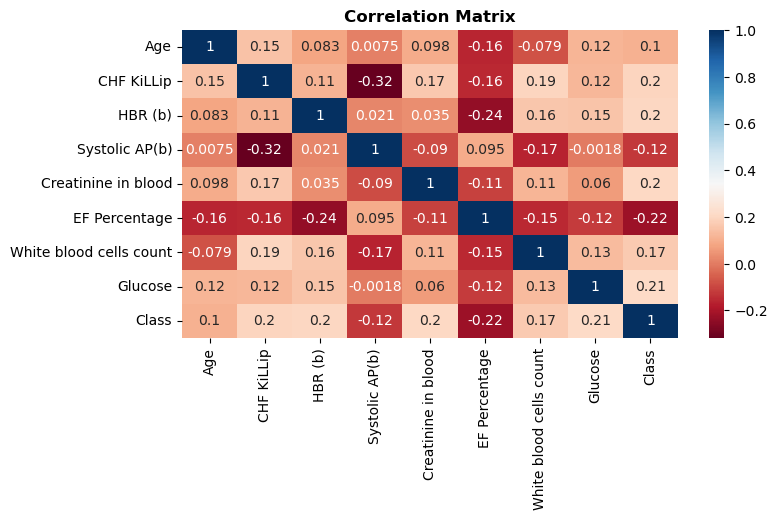

In [36]:
plt.figure(figsize = (8,4), dpi=100)
ax = plt.axes()
sns.heatmap(final_df.corr(), annot = True, cmap='RdBu', ax=ax)
ax.set_title('Correlation Matrix', weight='bold')
plt.show()

In [25]:
neg, pos = np.bincount(final_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 3024
    Positive: 104 (3.44% of total)

